# Heterogenous Vehicle Routing Problem (HVRP)

The [Heterogeneous Vehicle Routing Problem](https://ieeexplore.ieee.org/document/8541149) is an operational management problem in the field of distribution and logistics. In this problem, routes have to be designed starting from a depot to the geographically spread customer zones with an objective to minimize distance or cost and fulfilling the customer demands.
The Vehicle Routing Problem is well know in computer science and logistics industry. The decision version of VRP is NP-Complete. \
Classical algorithms do exit to solve such kinds of problems but owing to the large time frame to work out a solution, they are infeasible for larger problem instances. \
This project was essentially to develop the software implementation of [the paper](https://arxiv.org/pdf/2110.06799.pdf) on HVRP which is a variant of a general Vehicle Routing Problem. The referenced paper describes an appropriate Hamiltonian for finding a solution.

# ADDENDA:
1. get input files
2. parse_input()
3. build_bqm
4. parse_output
5. CQM ??
6. numpy ??

In [ ]:
!pip install dwave.system

In [ ]:
from dwave.system import LeapHybridBQMSampler
from dimod import BinaryQuadraticModel, quicksum
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
# import hybrid

import time
import itertools
import numpy as np
import pandas as pd


# Manually Construct Problem Instance

In [ ]:
# Set-up the problem
# nodes
N = 3         # no. of nodes, excluding depot

# vehicles
V = 2        # types of vehicles
m = [1] * (V+1)   # no. of vehicles of each type
t = [1] * (V+1)   # fixed vehicle cost

# cost: indexing (i, a, v)
cost = [[[1e5, 1, 1], [1e5, 2, 2], [1e5, 2, 2], [1e5, 2, 2]],
     [[1e5, 1, 1], [1e5, 1, 1], [1e5, 1, 1], [1e5, 0, 0]],
     [[1e5, 1, 1], [1e5, 1, 1], [1e5, 1, 1], [1e5, 0, 0]],
     [[1e5, 1, 1], [1e5, 1, 1], [1e5, 1, 1], [1e5, 0, 0]]]

# demand
q = [1, 2, 3, 5]

# max capacities of trucks, Q
capacities = [0, 4, 4]

# Randomly Generate Problem Instance

In [ ]:
class Initializer:
    def __init__(self, N, V):
        self.N = N
        self.V = V

    def generate_instance(self):  # cost of travel

        N = self.N
        V = self.V

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(N) - 0.5) * 10
        yc = (np.random.rand(N) - 0.5) * 10

        instance = np.zeros([N, N, V])
        for iv in range(0, V):
            for ii in range(0, N):
                for jj in range(ii + 1, N):
                    instance[ii, jj, iv] = ((xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2) * np.random.rand(1)
                    instance[jj, ii, iv] = instance[ii, jj, iv]

        return xc, yc, instance

In [ ]:
save_x, save_y, save_instance = xc, yc, instance
save_N, save_V = 5, 3
save_capacities = capacities
save_q = q
save_t = t

In [ ]:
# Problem parameters
N = 16     # no. of cities
V = 4     # no. of vehicles

capacities = np.random.randint(7, size=V+1)
q = np.random.randint(10, size=N+1)
t = np.random.randint(10, size=V+1)   # fixed cost for each vehicle



In [ ]:
# Random problem instance
initializer = Initializer(N+1, V+1)  # +1 for depot
xc, yc, cost = initializer.generate_instance()


In [ ]:
print('cost matrix shape:', cost.shape)
# print('cost matrix:', cost)
print('capaccities:', capacities)
print('demand:', q)
print('fixed cost of vehicles:', t)

cost matrix shape: (17, 17, 5)
capaccities: [6 3 5 1 4]
demand: [0 2 8 1 9 0 7 3 9 0 2 3 9 4 1 7 2]
fixed cost of vehicles: [0 6 7 3 9]


# Visualize Problem Instance

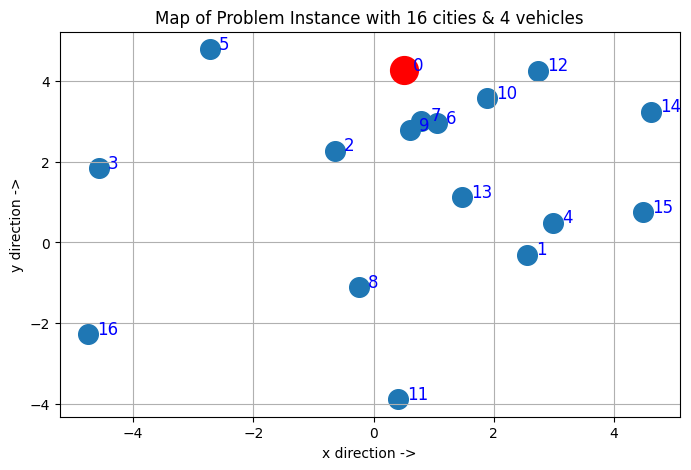

In [ ]:
def visualize_problem_instance(xc, yc):
    fig, ax = plt.subplots(1,1,figsize=(8, 5))
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=12, color="b")
    plt.plot(xc[0], yc[0], "ro", ms=20)

    plt.grid()

    plt.title("Map of Problem Instance with "+str(N)+" cities & "+str(V)+" vehicles")
    plt.xlabel('x direction ->')
    plt.ylabel('y direction ->')
    plt.show()


visualize_problem_instance(xc, yc)

# Declare Binary Variables
### Routing Variables
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $y_{i v}^{α}$ : ith node is visited by vehicle v at α timestep

### Capacity Variables
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $z_k^v$ : vehicle v has weight k when leaving the depot

In [ ]:
# Binary Variables

y = [[[f'y_[{i}][{a}][{v}]'.format(i, a, v) for v in range(V+1)]
      for a in range(N+1)]
      for i in range(N+1)]


# Opposite labeling for z: v, k'
z = [[f'z_[{v}][{k}]'.format(v, k) for k in range(capacities[v]+1)] for v in range(V+1)]


# 1. Routing Problem
##&nbsp; &nbsp; Variables used and there inter-conversion
* $x^v_{ij} : \mbox{type v vehicle goes through edge i → j}$
* $y^v_{iα} : \mbox{type v vehicle visits node i at alpha time step}$

&nbsp; &nbsp; $ y^v_{iα} $ holds information about how the path was traversed \\

$$ x^v_{ij} = \sum_{α=1}^{N_0 - 1} y^v_{iα} y^v_{jα} \\
x^v_{0i} = y^v_{i1} + \sum_{α=2}^{N_0}\left ( 1 - \sum_{j=1\\j≠i}^{N_0} y^v_{j \ α-1}\right ) y^v_{iα} \\
x^v_{i0} = y^v_{iN_0} + \sum_{α=1}^{N_0-1} y^v_{iα} \left ( 1 - \sum_{j=1\\j≠i}^{N_0} y^v_{j \ α+1}\right )  \\
$$


##&nbsp; &nbsp; Routing Problem Hamiltonian
Combined Hamiltonian for the routing problem can be written as:
$$ H = A ⋅ H_A + B ⋅ H_B + C ⋅ H_C + D ⋅ H_D $$

where individual terms are:
$$
 H_A = {\sum_{v=1}^{V} \sum_{i=1}^{N_0} \sum_{j=1}^{N_0} c_{i\ j}^{v} \sum_{α=1}^{N_0-1} y_{i\ α}^{v} y_{j\ α+1}^{v}}
  + {\sum_{v=1}^{V} \sum_{i=1}^{N_0} c_{0\ i}^{v} \left [ y_{i\ 1}^{v} + \sum_{α=2}^{N_0} \left ( 1 - \sum_{j=1 \\ j ≠ i}^{N_0} y_{j\ α-1}^{v} \right ) y_{i\ α}^{v}  \right ] }
  + {\sum_{v=1}^{V} \sum_{i=1}^{N_0} c_{i\ 0}^{v} \left [ y_{i\ N_0}^{v} + \sum_{α=1}^{N_0-1} y_{i\ α}^{v} \left ( 1 - \sum_{j=1 \\ j ≠ i}^{N_0} y_{j\ α+1}^{v} \right )   \right ]}
$$

$$
H_B = \sum_{j=1}^{N_0} \sum_{v=1}^{V} t^{v} \sum_{α=2}^{N_0} \left ( 1-\sum_{i=1}^{N_0} y_{i\ α-1}^{v} \right )  y_{j\ α}^{v}
$$

$$
H_C = \sum_{i=1}^{N_0} \left ( 1-\sum_{α=1}^{N_0} \sum_{v=1}^{V} y_{i\ α}^{v} \right ) ^ 2
$$

$$
H_D = \sum_{α=1}^{N_0} \left ( 1-\sum_{i=1}^{N_0} \sum_{v=1}^{V} y_{i\ α}^{v} \right ) ^ 2
$$

In [ ]:
def build_routing_bqm(bqm, A, B, C, D):
  # y = [[[f'y_[{i}][{a}][{v}]'.format(i, a, v) for v in range(V+1)]
  #       for a in range(N+1)]
  #       for i in range(N+1)]



  # ------------------------------ Add constant --------------------------------
  bqm.offset += (C*N + D*N)

  # ------------------------------ Add linear --------------------------------
  # HA (2)
  for v in range(1, V+1):
    for i in range(1, N+1):
      bqm.add_variable(y[i][1][v], A*cost[0][i][v])
      for a in range(2, N+1):
        bqm.add_variable(y[i][a][v], A*cost[0][i][v])

  # HA (3)
  for v in range(1, V+1):
    for i in range(1, N+1):
      bqm.add_variable(y[i][N][v], A*cost[i][0][v])
      for a in range(1, N):
        bqm.add_variable(y[i][a][v], A*cost[i][0][v])

  # HB
  for j in range(1, N+1):
    for v in range(1, V+1):
      for a in range(2, N+1):
        bqm.add_linear(y[j][a][v], B*t[v])

  # HC
  for i in range(1, N+1):
    for a in range(1, N+1):
      for v in range(1, V+1):
        bqm.add_variable(y[i][a][v], -C)

  # HD
  for a in range(1, N+1):
    for i in range(1, N+1):
      for v in range(1, V+1):
        bqm.add_variable(y[i][a][v], -D)




  # ---------------------------- Add quadratic -------------------------------
  # HA (1)
  for v in range(1, V+1):
    for i in range(1, N+1):
      for j in range(1, N+1):
        for a in range(1, N):
          bqm.add_quadratic(y[i][a][v], y[j][a+1][v], A*cost[i][j][v])

  # HA (2)
  for v in range(1, V+1):
    for i in range(1, N+1):
      for a in range(2, N+1):
        for j in range(1, N+1):
          if i == j: continue
          bqm.add_quadratic(y[j][a-1][v], y[i][a][v], -A*cost[0][i][v])

  # HA (3)
  for v in range(1, V+1):
    for i in range(1, N+1):
      for j in range(1, N+1):
        for a in range(1, N):
          bqm.add_quadratic(y[i][a][v], y[j][a+1][v], A*cost[i][j][v])

  # HB
  for j in range(1, N+1):
    for v in range(1, V+1):
      for a in range(2, N+1):
        for i in range(1, N+1):
          bqm.add_quadratic(y[i][a-1][v], y[j][a][v], -B*t[v])

  # HC
  for i in range(1, N+1):
    for a in range(1, N+1):
      for b in range(a+1, N+1):
        for u in range(1, V+1):
          for v in range(u+1, V+1):
            bqm.add_quadratic(y[i][a][u], y[i][b][v], 2*C)

  # HD
  for a in range(1, N+1):
    for i in range(1, N+1):
      for j in range(i+1, N+1):
        for u in range(1, V+1):
          for v in range(u+1, V+1):
            bqm.add_quadratic(y[i][a][u], y[j][a][v], 2*D)


  # ------------------------------ Return BQM --------------------------------
  return bqm


# Capacity Problem in HVRP
This notebook contains the implementation of Capacity Problem in Heterogeneous Vehicle Routing Problem. \
This is essentially an extension of the Knapsack problem disussed in this [notebook](https://colab.research.google.com/drive/1ci-Yk04bdn2CmSJ60wmDo6jtHAorzyMk?usp=sharing). Instead of considering only one vehicle (in Knapsack), we consider $V$ such vehicles, each with maximum capacity $Q^v$.

In [ ]:
def build_capacity_bqm(bqm, E):
  # Add bias
  bqm.offset += E*V

  # Add linear
  # H_E (1)
  for v in range(1, V+1):
    for k in range(capacities[v]+1):
      bqm.add_linear(z[v][k], -E)

  # H_E (2)(1)
  for v in range(1, V+1):
    for k in range(capacities[v]+1):
      bqm.add_linear(z[v][k], E)

  # H_E (2)(2)
  for v in range(1, V+1):
    for a in range(1, N+1):
      for i in range(1, N+1):
        bqm.add_linear(y[i][a][v], E*q[i])


  # Add quadratic
  # H_E (1)
  for v in range(1, V+1):
    for k in range(capacities[v]+1):
        for l in range(k+1, capacities[v]+1):
          bqm.add_quadratic(z[v][k], z[v][l], 2*E)

  # H_E (2)(1)
  for v in range(1, V+1):
    for k in range(capacities[v]+1):
      for l in range(k+1, capacities[v]+1):
        bqm.add_quadratic(z[v][k], z[v][l], 2*E*k*l)

  # H_E (2)(2)
  for v in range(1, V+1):
    for a in range(1, N+1):
      for i in range(1, N+1):
        for b in range(a+1, N+1):
          for j in range(i+1, N+1):
            bqm.add_quadratic(y[i][a][v], y[j][b][v], 2*E*q[i]*q[j])

  # H_E (2)(3)
  for v in range(1, V+1):
    for k in range(capacities[v]+1):
      for a in range(1, N+1):
        for i in range(1, N+1):
          bqm.add_quadratic(y[i][a][v], z[v][k], -2*E*k*q[i])


  return bqm

In [ ]:
def parse_input(filename):
  None

In [ ]:
def parse_output(sampleset):
  lowest_energy = sampleset.first.energy

  lowest_energy_sols = np.where(sampleset.record.energy == lowest_energy)

  # feasible_sols = np.where(sampleset.record.is_feasible==True)
  # first_feasible = np.where(sampleset.record[feasible_sols[0][0]][0]==1)

  #return best, first_feasible, feasible_sols


  # print('\nSampleset information:', sampleset.info)
  # print(sampleset)

  # print('\n\n', sampleset)

  # all lowest energy solutions
  # lowest_energy_sols = [sampleset.record[i] for i in lowest_energy_sols]

  return lowest_energy, sampleset.record[lowest_energy_sols[0]]

# Driver Code ($\_\_$_main_$\_\_$)


In [ ]:

################################################################################
######                            BUILDING BQM                            ######
################################################################################
start = time.time()

A, B, C, D, E = [1, 1, 8, 8, 2]
bqm = BinaryQuadraticModel('BINARY')
bqm = build_routing_bqm(bqm, A, B, C, D)
bqm = build_capacity_bqm(bqm, E)

end = time.time()
print(f'building bqm took {end-start} s')



################################################################################
######                            SAMPLING BQM                            ######
################################################################################
api_token = 'DEV-3c6d4cffb976a740b00036ffef7cf64f45017f7e'

start = time.time()

sampler = LeapHybridBQMSampler(token=api_token)
print(f'Submitting BQM to solver {str(sampler.solver.name)}')
sampleset = sampler.sample(bqm, label='HVRP Samples')

end = time.time()
print(f'sampler took {end-start} s')


################################################################################
######                            CHECK OUTPUT                            ######
################################################################################

lowest_energy, lowest_energy_sol = parse_output(sampleset)


print('\nlowest energy:', lowest_energy)
print('\n\n',lowest_energy_sol)

IndexError: ignored

In [ ]:
# bqm.variables     # stores the values of binary variables

# var_vals = dict()
# for i in range(len(bqm.variables)):
#   var_vals[bqm.variables[i]] = lowest_energy_sols[0][0][0][i]
# var_vals.keys()
# np.array(list(var_vals.values()))

In [ ]:
solution, energy = lowest_energy_sol[0][0], lowest_energy_sol[0][1]

print('Energy of solution:', energy)
print('values of binary variables:', solution)

Energy of solution: -11659.658316899195
values of binary variables: [0 1 0 ... 1 1 1]


In [ ]:
y, z = solution[:N**2 * V], solution[N**2 * V:]

In [ ]:
# Visualize the solution

def visualize_solution(xc, yc, x_flat, C, n, K, title_str):
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "ro", ms=20)

    plt.grid()

    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=1, vmax=K)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)
    cb = plt.colorbar(scalarMap, ax = ax, pad=.025)
    cb.ax.set_title(r'K')
    cb.set_ticks(np.arange(1,K+1))

    x_arr = np.reshape(x_flat, ((n+1)**2, K))
    for iv in range(0, K):
        x = x_arr[:,iv]
        colorVal = scalarMap.to_rgba(iv+1)
        for ii in range(0, (n+1)**2):
            if x[ii] > 0:
                ix, iy = ii//(n+1), ii%(n+1)
                plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=0.25, color=colorVal)

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

In [ ]:

def f_y_to_x(sol):

    x_ij_temp = np.zeros((N, N, V))  # xij, not incl depot

    y_i_alpha = np.reshape(sol, (N,N,V))

    for i in range(0, N):
        for j in range(0, N):
            for a in range(0, N-1):
                x_ij_temp[i,j,:] += y_i_alpha[i,a,:] * y_i_alpha[j,a+1,:]

    x_ij_full = np.zeros((N+1, N+1, V))

    x_ij_full[1:,1:,:] = x_ij_temp

    for i in range(0, N):
        x_ij_full[0,i+1] += y_i_alpha[i,0]
        for a in range(1, N):
            x_ij_full[0,i+1] += y_i_alpha[i,a]
            for j in range(0, N):
                if j!=i:
                    x_ij_full[0,i+1,:] += -y_i_alpha[j,a-1,:] * y_i_alpha[i,a,:]

    for i in range(0, N):
        x_ij_full[i+1,0,:] += y_i_alpha[i,-1,:]
        for a in range(0, N-1):
            x_ij_full[i+1,0,:] += y_i_alpha[i,a,:]
            for j in range(0, N):
                if j!=i:
                    x_ij_full[i+1,0,:] += -y_i_alpha[j,a+1,:] * y_i_alpha[i,a,:]

    return x_ij_full

In [ ]:
x_ij_q = f_y_to_x(y)

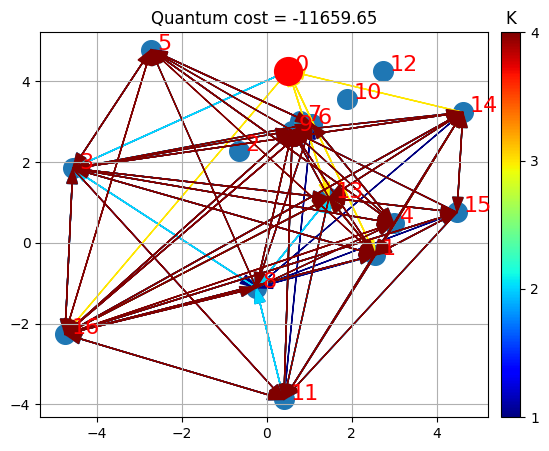

In [ ]:
visualize_solution(xc, yc, x_ij_q.flatten(), energy, N, V, "Quantum")